In [ ]:
import torch
import matplotlib.pyplot as plt
from math import log2
from utils import *

In [ ]:
x = torch.rand(50,50,3)

<matplotlib.image.AxesImage>

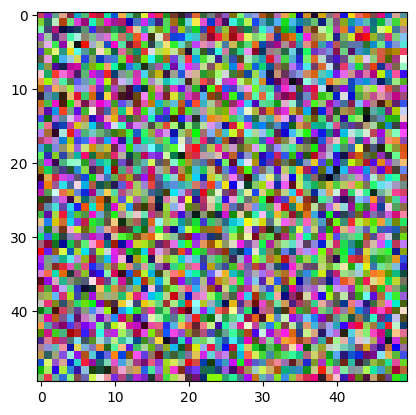

In [ ]:
plt.imshow(x)

We can discretize image by putting similar float values into the same buckets.

In [ ]:
# number of buckets
def quantize(x, n_bins, as_pixels=False):
    buckets = torch.linspace(0, 1, n_bins+1)
    res = torch.bucketize(x, buckets)-1
    if not as_pixels: return res
    return (buckets[res]*256).type(torch.uint8)

In [ ]:
k = 2
x_m = quantize(x, k, True)

Text(0.5, 1.0, '3.0 bit image')

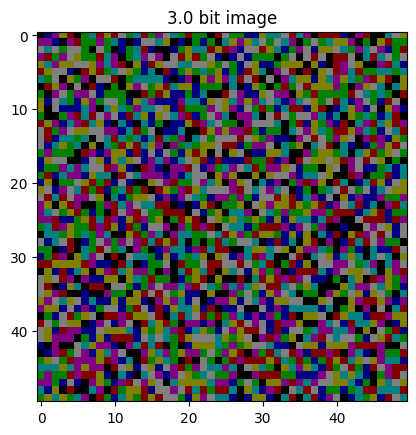

In [ ]:
plt.imshow(x_m)
plt.title(f"{3*log2(k)} bit image")

Now we'll look closer at a single channel of the image.

In [ ]:
x = x[:,:,0].clone()

<matplotlib.image.AxesImage>

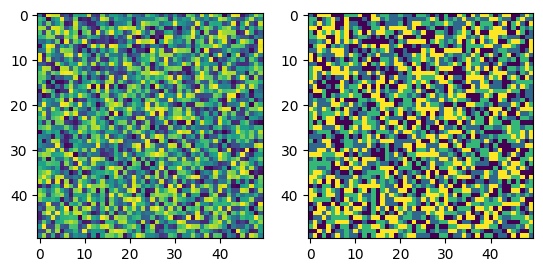

In [ ]:
axes = plt.subplots(ncols=2)[1]
axes[0].imshow(x)
axes[1].imshow(quantize(x,4))

In [ ]:
def step(x, rad=4):
    w,h = x.shape
    out = torch.zeros_like(x)
    for i in range(w):
        for j in range(h):
            block = x[max(i-rad,0):min(i+rad,w), max(j-rad,0):min(j+rad,h)]
            color = torch.argmax(torch.bincount(block.flatten()))
            out[i,j]=color
    return out

def steps(x, n=1):
    for _ in range(n):
        x = step(x)
    return x

In [ ]:
y = quantize(x, 2)

<matplotlib.image.AxesImage>

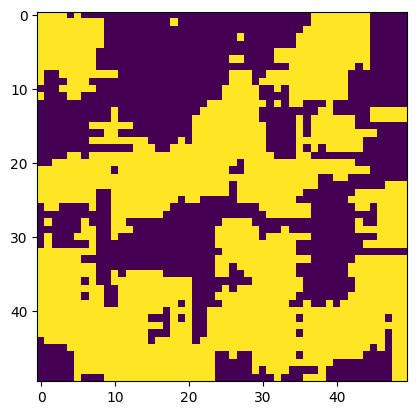

In [ ]:
plt.imshow(step(y))

In [ ]:
mod = load_cu_file('./mode_filter.cu', False)

In [ ]:
y = y.type(torch.int32)

In [ ]:
mod.mode_filter2d(y.cuda(), 3)

tensor([[1, 0, 1,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], device='cuda:0', dtype=torch.int32)

<matplotlib.image.AxesImage>

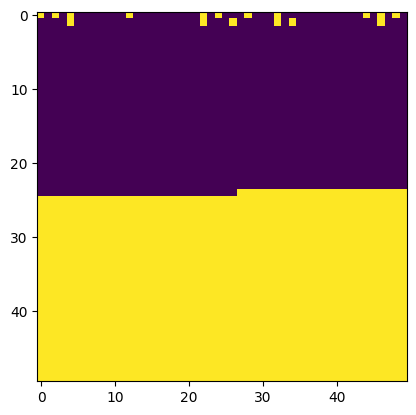

In [ ]:
plt.imshow(mod.mode_filter2d(y.cuda(), 3).cpu())

In [ ]:
import os
os.environ['NUMBA_ENABLE_CUDASIM'] = "1"

In [ ]:
import torch
import numpy as np
from numba import cuda
import numba

@cuda.jit
def mode_filter2d_k(input, output, w, h, r, k):
    x, y = cuda.grid(2)
    if x >= w or y >= h:
        return

    count = cuda.shared.array(shape=(32,32,2), dtype=numba.int32)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    for i in range(x - r, x + r + 1):
        for j in range(y - r, y + r + 1):
            if i >= 0 and i < w and j >= 0 and j < h:
                count[tx,ty,input[i,j]] +=1

    max_val = 0
    idx_max = 0
    for i in range(k):
        m = count[tx, ty,i]
        if m > max_val:
            idx_max = i
            max_val = m

    output[x, y] = idx_max

def mode_filter2d(input, r):
    assert input.is_cuda, "Input must be a CUDA tensor"

    output = torch.empty_like(input)
    k = len(torch.unique(input))
    assert input.max().item() == k - 1 and input.min().item() == 0, "input must be a tensor of integers from 0 to k-1"

    w, h = input.size(0), input.size(1)
    blockdim = (32, 32)
    griddim = (w // blockdim[0] + 1, h // blockdim[1] + 1)

    mode_filter2d_k[griddim, blockdim](input, output, w, h, r, k)

    return output

y = quantize(torch.rand(50,50), 2).cuda()
mode_filter2d(y, 3)

IndexError: tid=[11, 29, 0] ctaid=[0, 0, 0]: index 51 is out of bounds for dimension 0 with size 50

In [ ]:
y = y.cuda()
mode_filter2d(y, 3)

/home/slakter/coding/py-playground/.conda/lib/python3.11/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], device='cuda:0')